# Finetuning moondream on Captcha dataset

This notebook demonstrates how to fine-tune moondream to improve performance on a downstream task.
For this example, we'll fine-tune on the https://huggingface.co/datasets/project-sloth/captcha-images dataset.

In [2]:
%pip install torch transformers timm einops datasets bitsandbytes accelerate flash_attn

  Using cached transformers-4.47.1-py3-none-any.whl.metadata (44 kB)
  Using cached timm-1.0.12-py3-none-any.whl.metadata (51 kB)
  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl.metadata (2.9 kB)
  Using cached accelerate-1.2.1-py3-none-any.whl.metadata (19 kB)
  Using cached flash_attn-2.7.2.post1.tar.gz (3.1 MB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 83.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 105.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 26.5 MB/s eta 0:00:00
  

In [20]:
!pip install flash-attn --no-build-isolation

In [21]:
from torch.utils.data import Dataset
from datasets import load_dataset

class CaptchaDataset(Dataset):
    def __init__(self, split='train', cache_dir="/data",):
        # Specify the cache directory for downloading the dataset
        self.data = load_dataset(
            "project-sloth/captcha-images",
              trust_remote_code=True, 
              cache_dir=cache_dir,
              revision="refs/convert/parquet")[split]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {
            "image": sample["image"],  # Should be a PIL image
            "qa": [
                {
                    "question": "What does the text say?",
                    "answer": sample["solution"],
                }
            ]
        }

datasets = {
    "train" : CaptchaDataset("train"),
    "val" : CaptchaDataset("validation"),
    "test" : CaptchaDataset("test"),
}

No config specified, defaulting to the single config: captcha-images/default
Loading Dataset Infos from /opt/conda/lib/python3.11/site-packages/datasets/packaged_modules/parquet
Generating dataset captcha-images (/data/project-sloth___captcha-images/default/0.0.0/f94b30aa994ef37a9c979d7dab68f37c93724252)


0000.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/7.00M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/6.96M [00:00<?, ?B/s]

Checksum Computation took 0.0 min
Generating train split


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split


Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split


Generating test split: 0 examples [00:00, ? examples/s]

Unable to verify splits sizes.
Dataset captcha-images downloaded and prepared to /data/project-sloth___captcha-images/default/0.0.0/f94b30aa994ef37a9c979d7dab68f37c93724252. Subsequent calls will reuse this data.
No config specified, defaulting to the single config: captcha-images/default
Loading Dataset Infos from /opt/conda/lib/python3.11/site-packages/datasets/packaged_modules/parquet
Overwrite dataset info from restored data version if exists.
Loading Dataset info from /data/project-sloth___captcha-images/default/0.0.0/f94b30aa994ef37a9c979d7dab68f37c93724252
Found cached dataset captcha-images (/data/project-sloth___captcha-images/default/0.0.0/f94b30aa994ef37a9c979d7dab68f37c93724252)
Loading Dataset info from /data/project-sloth___captcha-images/default/0.0.0/f94b30aa994ef37a9c979d7dab68f37c93724252
No config specified, defaulting to the single config: captcha-images/default
Loading Dataset Infos from /opt/conda/lib/python3.11/site-packages/datasets/packaged_modules/parquet
Over

Now let's take a look at a sample image from the training set and compare the ground-truth answers
with moondream predictions.

In [22]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-07-23"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/319 [00:00<?, ?B/s]

configuration_moondream.py:   0%|          | 0.00/3.34k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/5.38k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

vision_encoder.py:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.73G [00:00<?, ?B/s]

PhiForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

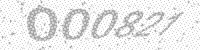


Question: What does the text say?

Ground Truth: 000821

Moondream: The text in the center of the image says "00082!"


In [25]:
from IPython.display import display

sample = datasets['train'][5]
display(sample['image'])

for qa in sample['qa']:
    print('\nQuestion:', qa['question'])
    print('\nGround Truth:', qa['answer'])
    print('\nMoondream:', moondream.answer_question(
        moondream.encode_image(sample['image']),
        qa['question'],
        tokenizer=tokenizer,
    ))

Let's start setting up hyperparameters for finetuning.

In [36]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 3

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory.
BATCH_SIZE = 16

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 2

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 1e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = False


This next block will start the training process.

In [37]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    images = [moondream.vision_encoder.preprocess(image) for image in images]

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}{ANSWER_EOS}",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images,
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder(images)
        # Todo: should we get the projection here?Sx`` 

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    )
}

moondream.text_model.train()
moondream.text_model.transformer.gradient_checkpointing_enable()

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            })

if USE_WANDB:
    wandb.finish()

Epoch 3/3: 100%|██████████████████████████████| 375/375 [13:02<00:00,  2.09s/it]


In [38]:
moondream.save_pretrained("checkpoints/moondream-ft")

Now that training has completed, let's inspect a few samples and calculate accuracy.

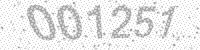

Question: What does the text say?
Ground Truth: 001251
Moondream: 001251


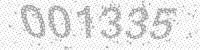

Question: What does the text say?
Ground Truth: 001335
Moondream: 001335


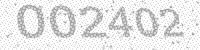

Question: What does the text say?
Ground Truth: 002402
Moondream: 002402


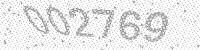

Question: What does the text say?
Ground Truth: 002769
Moondream: 002769


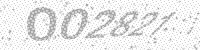

Question: What does the text say?
Ground Truth: 002821
Moondream: 002221


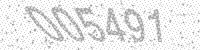

Question: What does the text say?
Ground Truth: 005491
Moondream: 005491


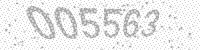

Question: What does the text say?
Ground Truth: 005563
Moondream: 005563


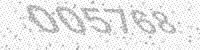

Question: What does the text say?
Ground Truth: 005768
Moondream: 005768


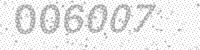

Question: What does the text say?
Ground Truth: 006007
Moondream: 006007


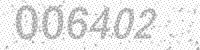

Question: What does the text say?
Ground Truth: 006402
Moondream: 006402


In [39]:
moondream.eval()

for i, sample in enumerate(datasets['test']):
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
        num_beams=4,
        no_repeat_ngram_size=5,
        early_stopping=True
    )

    if i < 10:
        display(sample['image'])
        print('Question:', sample['qa'][0]['question'])
        print('Ground Truth:', sample['qa'][0]['answer'])
        print('Moondream:', md_answer)
    else:
        break


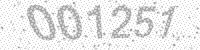

Question: What does the text say?
Ground Truth: 001251
Moondream: 001251


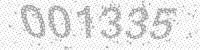

Question: What does the text say?
Ground Truth: 001335
Moondream: 001335


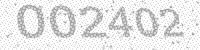

Question: What does the text say?
Ground Truth: 002402
Moondream: 002402


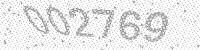

Question: What does the text say?
Ground Truth: 002769
Moondream: 002769


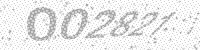

Question: What does the text say?
Ground Truth: 002821
Moondream: 002221


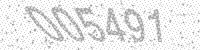

Question: What does the text say?
Ground Truth: 005491
Moondream: 005491


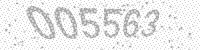

Question: What does the text say?
Ground Truth: 005563
Moondream: 005563


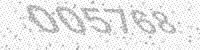

Question: What does the text say?
Ground Truth: 005768
Moondream: 005768


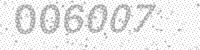

Question: What does the text say?
Ground Truth: 006007
Moondream: 006007


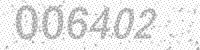

Question: What does the text say?
Ground Truth: 006402
Moondream: 006402


Accuracy : 74.60%


In [41]:
moondream.eval()

correct_count = 0
for i, sample in enumerate(datasets['test']):
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
        num_beams=4,
        no_repeat_ngram_size=5,
        early_stopping=True
    )

    if md_answer == sample["qa"][0]["answer"]:
        correct_count += 1

    if i < 10:
        display(sample['image'])
        print('Question:', sample['qa'][0]['question'])
        print('Ground Truth:', sample['qa'][0]['answer'])
        print('Moondream:', md_answer)
    
print(f"\n\nAccuracy : {correct_count / len(datasets['test'])*100:.2f}%" )